##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Black Scholes: Price and Implied Vol in TFF

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.google.com/url?q=https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Black_Scholes_Price_and_Implied_Vol.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Black_Scholes_Price_and_Implied_Vol.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
#@title Upgrade to TensorFlow 2.1+
!pip install --upgrade tensorflow

In [0]:
#@title Install TF Quant Finance
!pip install tf-quant-finance

In [0]:
#@title Imports

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tf_quant_finance as tff 

option_price = tff.black_scholes.option_price
implied_vol = tff.black_scholes.implied_vol

from IPython.core.pylabtools import figsize
figsize(21, 14) # better graph size for Colab  

# Black Scholes pricing and implied volatility usage

Here we see how to price vanilla options in the Black Scholes framework using the library. 

## Semantics of the interface

If $S$ is the spot price of an asset, $r$ the risk free rate, $T$ the time to expiry, $\sigma$ the volatility. The price of a call $C$ under [Black Scholes](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#Black%E2%80%93Scholes_formula) model exhibits the following relationship (suppressing unusued notation):

$C(S, r) = e^{-rT} C(e^{rT}S, 0)$

Where $e^{-rT}$ is the discount factor, and $e^{rT}S_t$ the forward price of the asset to expiry. The `tff`'s interface is framed in terms of forward prices and discount factors (rather than spot prices and risk free rates). This corresponds to the right hand side of the above relationship.

## Parallelism

Note that the library allows pricing of options in parallel: each argument (such as the `strikes`) is an array and each index corresponds to an independent option to price. For example, this allows the simultaneous pricing of the same option with different expiry dates, or strike prices or both.


In [0]:
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
prices

<tf.Tensor: id=22630, shape=(4,), dtype=float64, numpy=array([0.14798729, 0.24216815, 0.74814549, 0.02260333])>

We now show how to invert the Black Scholes pricing model in order to recover the volatility which generated a given market price under a particular term structure. Again, the implied volatility interface operates on batches of options, with each index of the arrays corresponding to an independent problem to solve. 

In [0]:
# Initial positions for finding implied vol.
initial_volatilities = np.array([2.0, 0.5, 2.0, 0.5])
# Identifier whether the option is call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# Find the implied vols beginning at initial_volatilities.
implied_vols = implied_vol(
    prices=prices,
    strikes=strikes,
    expiries=expiries,
    forwards=forwards,
    discount_factors=discount_factors,
    is_call_options=is_call_options,
    initial_volatilities=initial_volatilities,
    validate_args=True,
    tolerance=1e-9,
    max_iterations=200,
    name=None,
    dtype=None)
implied_vols

<tf.Tensor: id=24393, shape=(4,), dtype=float64, numpy=array([0.7, 1.1, 2. , 0.5])>

Which should show that `implied_vols` is very close to the `volatilities` used to generate the market prices. Here we provided initial starting positions, however, by default `tff` will chose an adaptive initialisation position as discussed below.

# Black Scholes implied volatility convergence region

We now look at some charts which provide a basic illustration of the convergence region of the implemented root finding method.

The library provides an implied volatility root finding method. If not provided
with an initial starting point, a starting point will be found using the Radiocic-Polya approximation [1] to the implied volatility. This section illustrates both call styles and the comparitive advantage of using targeted initialisation.

In this example:

* Forward prices are fixed at 1.
* Strike prices are from uniform grid on (0, 5).
* Expiries are fixed at 1.
* Volatilities are from a uniform grid on (0, 5).
* Fixed initial volatilities (where used) are 1.
* Option prices were computed by tff.black_scholes.option_price on the other data.
* Discount factors are 1.


[1] Dan Stefanica and Rados Radoicic. [*An explicit implied volatility formula.*](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2908494) International Journal of Theoretical and Applied Finance. Vol. 20, no. 7, 2017.
    

In [0]:
#@title Example data on a grid.
def grid_data(strike_vec, vol_vec, dtype=np.float64):
  """Construct dummy data with known ground truth.
  
  For a grid of known strikes by volatilities, return the price.
  Assumes the forward prices and expiries are fixed at unity.
  
  Args:
    strikes: a vector of strike prices from which to form the grid.
    volatilities: a vector of volatilities from which to form the grid.
    dtype: a numpy datatype for the element values of returned arrays.
  
  Returns:
    (forwards, strikes, expiries, true_volatilities, prices) all of
    which are identically shaped numpy arrays.
  """
  nstrikes = len(strike_vec)
  nvolatilities = len(vol_vec)
  vol_ones = np.matrix(np.ones((1, nvolatilities)))
  strike_ones = np.matrix(np.ones((nstrikes, 1)))
  strikes = np.array(np.matrix(strike_vec).T * vol_ones, dtype=dtype)
  volatilities = np.array(strike_ones * np.matrix(vol_vec), dtype=dtype)
  expiries = np.ones_like(strikes, dtype=dtype)
  forwards = np.ones_like(strikes, dtype=dtype)
  initials = np.ones_like(strikes, dtype=dtype)
  prices = option_price(volatilities=volatilities,
                        strikes=strikes,
                        expiries=expiries,
                        forwards=forwards,
                        dtype=tf.float64)
  return (forwards, strikes, expiries, volatilities, initials, prices)

In [0]:
# Build a 1000 x 1000 grid of options find the implied volatilities of.
nstrikes = 1000
nvolatilities = 1000
strike_vec = np.linspace(0.0001, 5.0, nstrikes)
vol_vec = np.linspace(0.0001, 5.0, nvolatilities)
max_iterations = 50
grid = grid_data(strike_vec, vol_vec)
forwards0, strikes0, expiries0, volatilities0, initials0, prices0 = grid
initials0 = discounts0 = signs0 = np.ones_like(prices0)

In [0]:
# Implied volitilities, starting the root finder at 1.
implied_vols_fix = implied_vol(
    prices=prices0,
    strikes=strikes0,
    expiries=expiries0,
    forwards=forwards0,
    initial_volatilities=initials0,
    validate_args=False,
    tolerance=1e-8,
    max_iterations=max_iterations)

In [0]:
# Implied vols starting the root finder at the Radiocic-Polya approximation.
implied_vols_polya = implied_vol(
    prices=prices0,
    strikes=strikes0,
    expiries=expiries0,
    forwards=forwards0,
    validate_args=False,
    tolerance=1e-8,
    max_iterations=max_iterations)

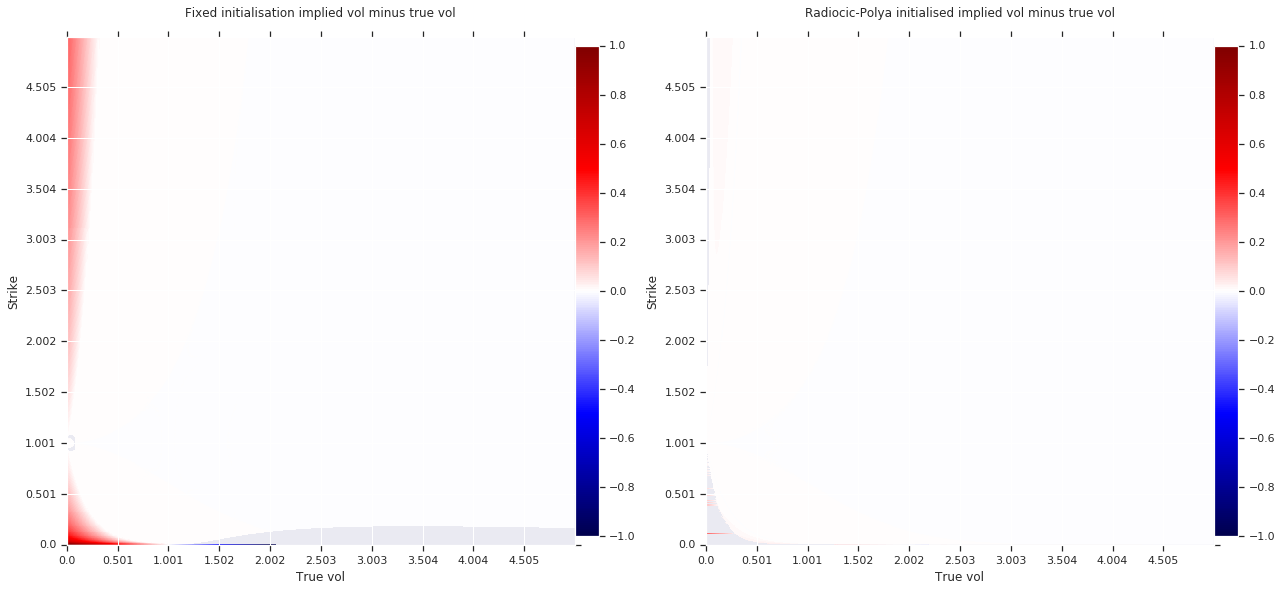

In [0]:
#@title Visualisation of accuracy
plt.clf()

thinner = 100
fig, _axs = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

implied_vols = [implied_vols_fix, implied_vols_polya]
titles = ["Fixed initialisation implied vol minus true vol", "Radiocic-Polya initialised implied vol minus true vol"]
vmin = np.min(map(np.min, implied_vols))
vmax = np.max(map(np.max, implied_vols))
images = []

for i in range(2):
  _title = axs[i].set_title(titles[i])
  _title.set_position([.5, 1.03])
  im = axs[i].imshow(implied_vols[i] - volatilities0, origin="lower", interpolation="none", cmap="seismic", vmin=-1.0, vmax=1.0)
  images.append(im)
  axs[i].set_xticks(np.arange(0, len(vol_vec), thinner))
  axs[i].set_yticks(np.arange(0, len(strike_vec), thinner))
  axs[i].set_xticklabels(np.round(vol_vec[0:len(vol_vec):thinner], 3))
  axs[i].set_yticklabels(np.round(strike_vec[0:len(strike_vec):thinner], 3))
  plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.00)
  axs[i].set_ylabel('Strike')
  axs[i].set_xlabel('True vol')

plt.show()
pass

Where the grey values represent `nan`s in the grid. Note that the bottom left corner of each image lies outside the bounds where inversion should be possible. The pattern of `nan` values for different values of a fixed initialisation strategy will be different (rerun the colab to see).

# Black Scholes implied volatility initialisation strategy accuracy comparison

We can also consider the median absolute error for fixed versus Radiocic-Polya initialisation of the root finder. We consider a clipped grid looking at performance away from the boundaries where extreme values or nans might occur.

In [0]:
# Indices for selecting the middle of the grid.
vol_slice = np.arange(int(0.25*len(vol_vec)), int(0.75*len(vol_vec)))
strike_slice = np.arange(int(0.25*len(strike_vec)), int(0.75*len(strike_vec)))

In [0]:
error_fix = implied_vols_fix.numpy() - volatilities0
error_fix_sub = [error_fix[i, j] for i, j in zip(strike_slice, vol_slice)]
# Calculate the median absolute error in the central portion of the the grid
# for the fixed initialisation.
median_error_fix = np.median( np.abs(error_fix_sub) )
median_error_fix

5.660064306134416e-09

In [0]:
error_polya = implied_vols_polya.numpy() - volatilities0
error_polya_sub = [error_polya[i, j] for i, j in zip(strike_slice, vol_slice)]
# Calculate the median absolute error in the central portion of the the grid
# for the Radiocic-Polya approximation.
median_error_polya = np.median( np.abs(error_polya_sub) )
median_error_polya

3.181876984115206e-11

In [0]:
median_error_fix / median_error_polya

177.88444790263713

So we see that both sets of implied volatilities have median absolute errors under the 1e-8 tolerance that we prescribed. However, adaptive initialisation of the root finder has improved the median accuracy of the final results by around two orders of magnitude.